In [1]:
%load_ext autoreload
%autoreload 2
    
import os
import sys
nb_dir = os.path.split(os.getcwd())[0]
if nb_dir not in sys.path:
    sys.path.append(nb_dir)
from utils import double_division_tracks, curated_tracks, DATA_ROOT

import numpy as np
import pandas as pd
from pathlib import Path
import cv2
from statsmodels.stats.proportion import proportions_ztest

%matplotlib inline
import matplotlib.cm as cm
from matplotlib import pyplot as plt
plt.style.use('_classic_test')
import seaborn as sns

from notebook_functions import timelapse_double_frame_sync

log_const = 300

## Spatial-time correlation

In [2]:
size = 20
df = pd.read_csv(DATA_ROOT / 'Spots in tracks statistics.csv', na_values="None", delimiter='\t', header=0,
                 usecols=['ID', 'TRACK_ID', 'POSITION_X', 'POSITION_Y', 'FRAME']).dropna().astype(int)
frames = sorted(df['FRAME'].unique())

In [204]:
def get_frame_average(img, coords, sz, fun=np.median):
    """Calculate `fun` across selected patches"""

    sz2 = sz // 2
    mask = np.zeros_like(img, dtype=bool)
    for y, x in coords:
        left, top = max(0, x - sz2), max(0, y - sz2)
        mask[top: y + sz2, left: x + sz2] = True
    return fun(img[mask])

def get_channel_intensities(coords, frame_num, channel_root, sz=20):
    """Get cell intensities for a channel"""

    sz2 = sz // 2
    frame_name = f'T{frame_num + 1:0>3}'
    img = cv2.imread(str(channel_root / frame_name), cv2.CV_16U)
    frame_average = get_frame_average(img, coords, sz)

    intensities = []
    for y, x in coords:
        left, top = max(0, x - sz2), max(0, y - sz2)
        intensity = np.median(img[top: y + sz2, left: x + sz2]) - frame_average
        intensities.append(intensity)
    return np.array(intensities)

def get_deltas(intensities, coords, skip_rate):
    intensity_delta = {}
    for channel in intensities.keys():
        delta_ = np.abs(intensities[channel][::skip_rate] - intensities[channel][::skip_rate][..., np.newaxis])
        intensity_delta[channel] = delta_[np.tril_indices(len(delta_), k=-1)]
        
    coords_squared = np.sum(coords[::skip_rate] * coords[::skip_rate], 1, keepdims=True)
    sp_delta = np.sqrt(coords_squared + coords_squared.T - 2 * np.dot(coords[::skip_rate], coords[::skip_rate].T))
    sp_delta = sp_delta[np.tril_indices(len(sp_delta), k=-1)]
    return intensity_delta, sp_delta

def process_frame(df, frame_num, size, skip_rate=10):
    coords = df.loc[df['FRAME'] == frame_num, ['POSITION_Y', 'POSITION_X']].values
    intensities = {}
    for channel in ['GFP', 'Cy3']:
        channel_root = DATA_ROOT / channel
        intensities[channel] = get_channel_intensities(coords, frame_num, channel_root, sz=size)
    return get_deltas(intensities, coords, skip_rate=skip_rate)

In [78]:
frame_num = 100
intensity_delta, sp_delta = process_frame(df, frame_num, size)

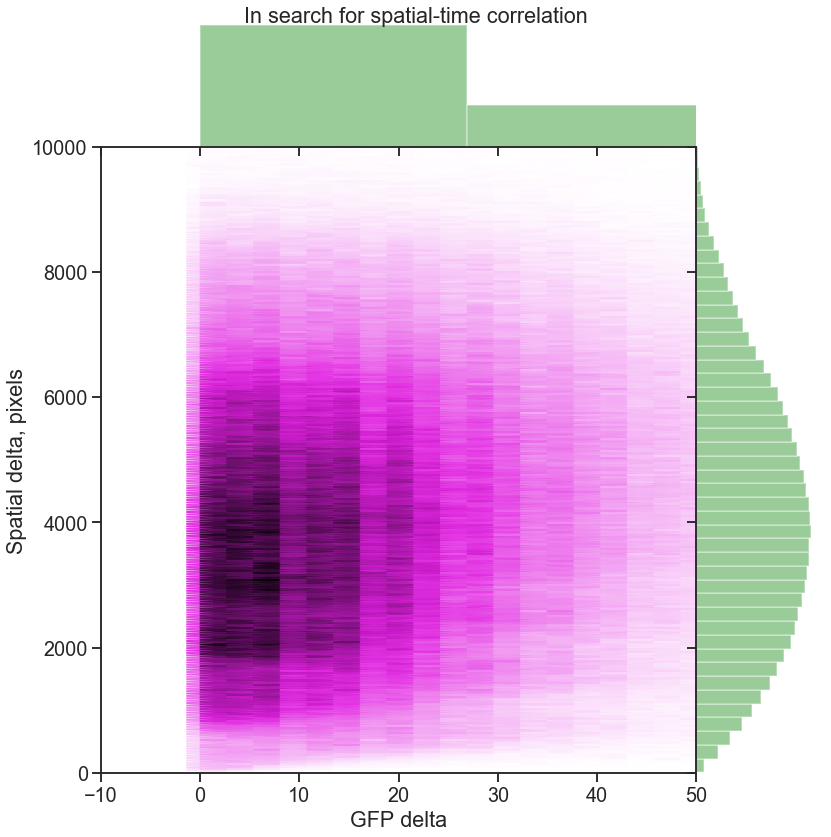

In [59]:
sns.set(style='ticks', color_codes=True)
sns.set_context('talk', font_scale=1.2, rc={'lines.linewidth': 3.0})

channel = 'GFP'
g = sns.jointplot(x=channel + ' delta', y='Spatial delta, pixels',
                  data=pd.DataFrame(data={channel + ' delta': intensity_delta[channel], 'Spatial delta, pixels': sp_delta}),
                  xlim=(-10, 50),
                  ylim=(0, 10000),
                  color="violet",
                  space=0,
                  kind="hex",
                  height=12,
                  ratio=5,
                  joint_kws={"gridsize": 500},
                  marginal_kws={'color': 'green'})
_ = g.fig.suptitle('In search for spatial-time correlation')

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\figure.py:2369: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  warnings.warn("This figure includes Axes that are not compatible "


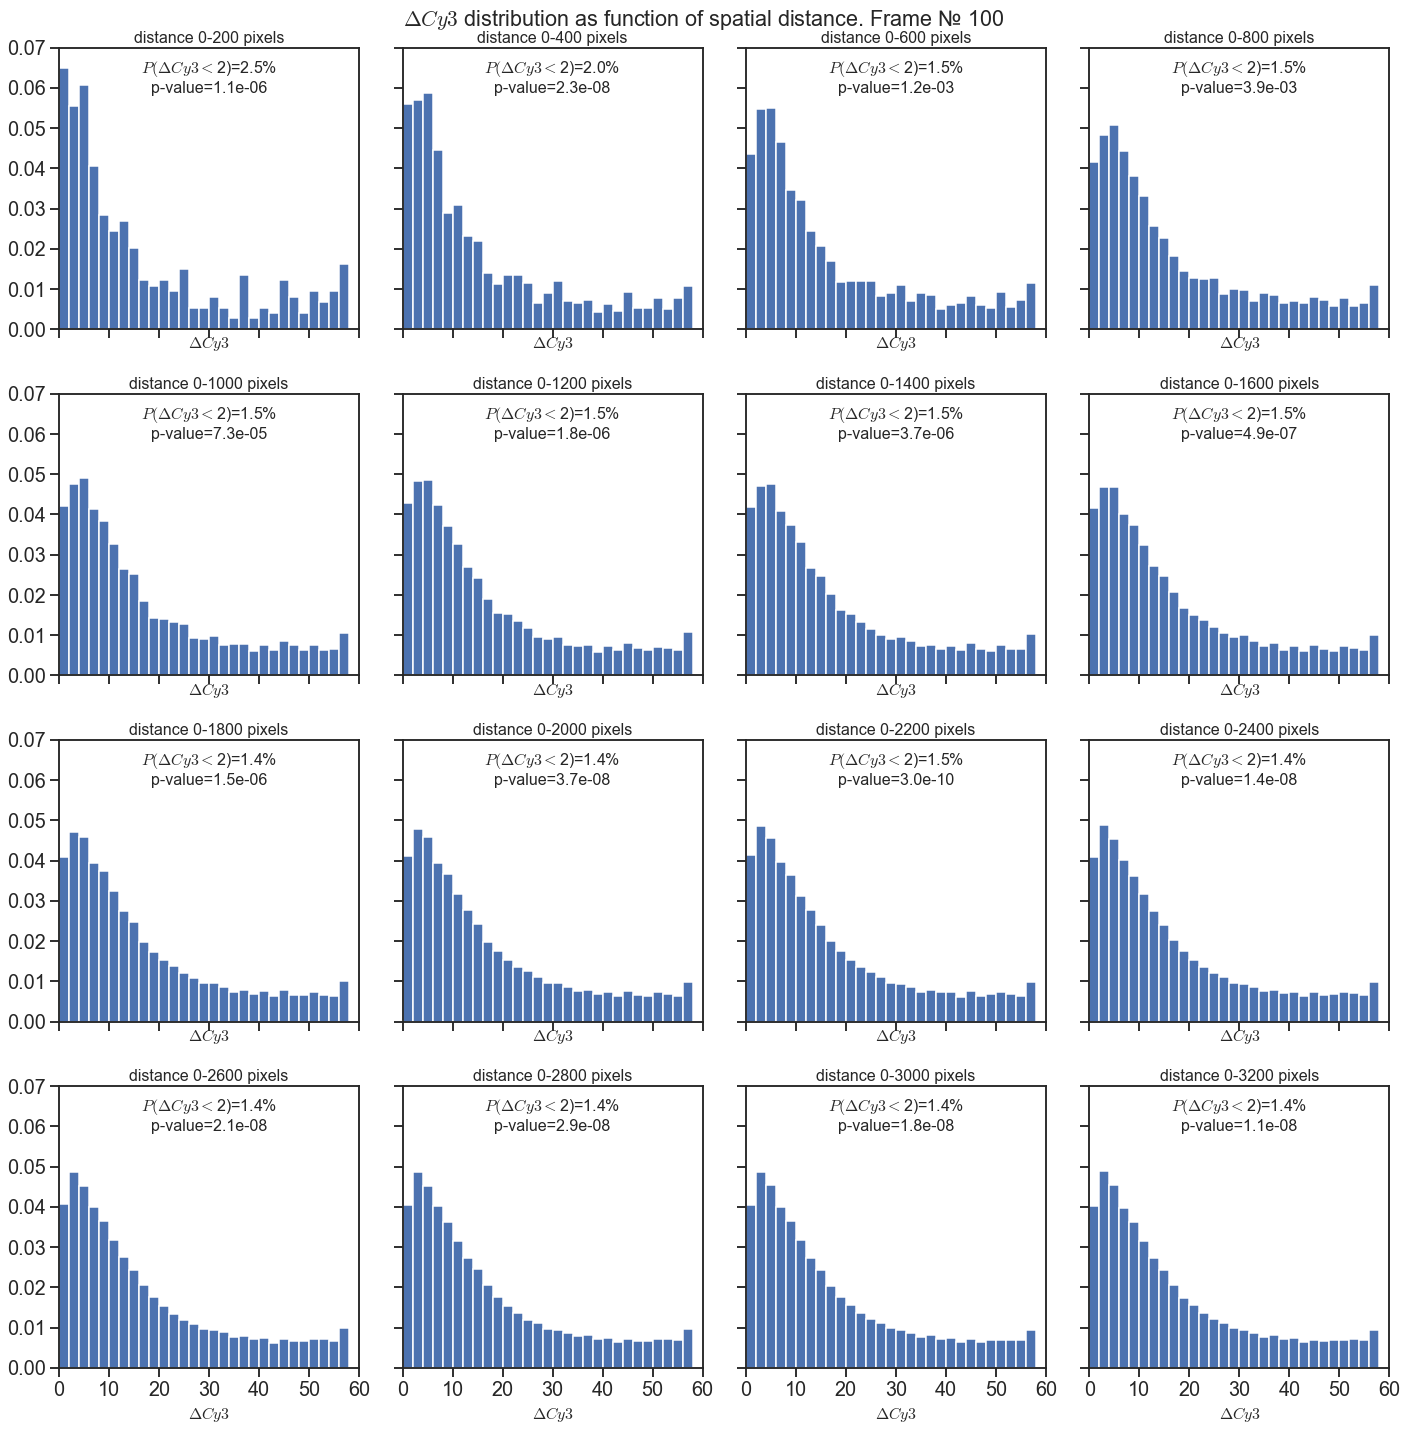

In [86]:
channel = 'Cy3'

width = 200
steps = np.arange(0, 3200, width)

min_intensity = 2
n_cols = int(np.ceil(np.sqrt(len(steps))))
n_rows = int(np.ceil(len(steps) / n_cols))
fontsize = 16
fig, axs = plt.subplots(n_rows, n_cols, figsize=(5 * n_cols, 5 * n_rows), sharex=True, sharey=True,
                        tight_layout=True)
for i, step in enumerate(steps):
    ax = axs[i // n_cols, i % n_cols]
    band = (step, step + width)
    idx = np.logical_and(band[0] <= sp_delta, sp_delta < band[1])
    data = intensity_delta[channel][idx]
    prob = (data < min_intensity).sum() / len(data)
    
    count = [sum(data < min_intensity), sum(intensity_delta[channel] < min_intensity)]
    nobs = [len(data), len(intensity_delta[channel])]
    stat, pval = proportions_ztest(count, nobs, alternative='larger')
    
    ax.hist(data, density=True, bins=range(0, 60, 2))
    ax.set_title(f'distance {band[0]}-{band[1]} pixels', fontsize=fontsize)
    ax.set_xlabel(f'$\Delta {channel}$', fontsize=fontsize)
    ax.text(s=f'$P(\Delta {channel}<$' + f'{min_intensity})={prob * 100:0.1f}%\np-value={pval:0.1e}', x=0.5, y=0.9, horizontalalignment='center',
            verticalalignment='center', transform=ax.transAxes, fontsize=fontsize)

_ = plt.suptitle(f'$\Delta {channel}$ distribution as function of spatial distance. Frame № {frame_num}', y=1.0)

## 1. Plot how fraction of cells with similar intensity depends on the radius

In [89]:
frame_num = 0
intensity_delta, sp_delta = process_frame(df, frame_num, size)

In [119]:
channel = 'Cy3'
radius = list(range(50, 2500, 50))
min_intensity_difference = 2
fractions = []
for r in radius:
    data = intensity_delta[channel][sp_delta < r]
    fraction = (data < min_intensity_difference).sum() / len(data)
    fractions.append(fraction)

Text(0.5, 1.0, 'Fraction of cells with similar intensities. Cy3, frame 0')

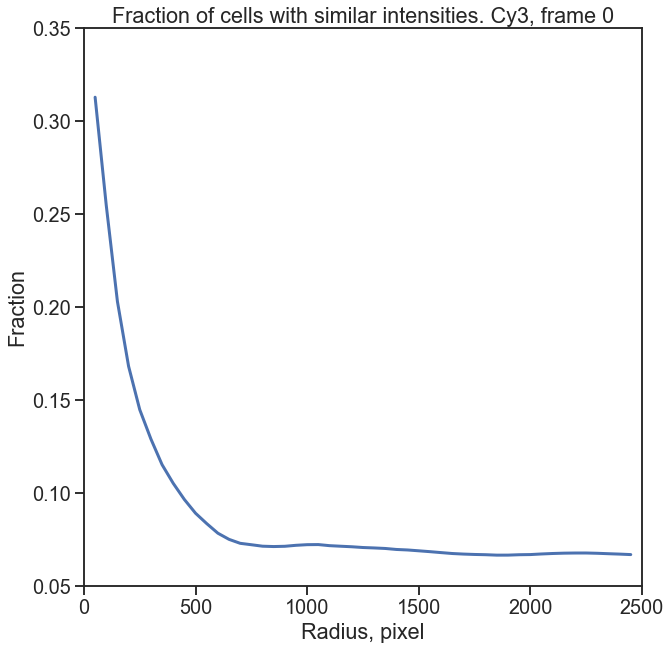

In [120]:
plt.figure(figsize=(10, 10))
plt.plot(radius, fractions)
plt.xlabel('Radius, pixel')
plt.ylabel('Fraction')
_ = plt.title(f'Fraction of cells with similar intensities. {channel}, frame {frame_num}')

## 2. Plot how fraction of cells with similar intensity depends on the frame number

In [ ]:
channel = 'Cy3'
min_intensity_difference = 2
fractions = []
radius = 50
frames = range(200)
for frame_num in frames:
    print(frame_num)
    intensity_delta, sp_delta = process_frame(df, frame_num, size)
    data = intensity_delta[channel][sp_delta < radius]
    fraction = (data < min_intensity_difference).sum() / len(data)
    fractions.append(fraction)

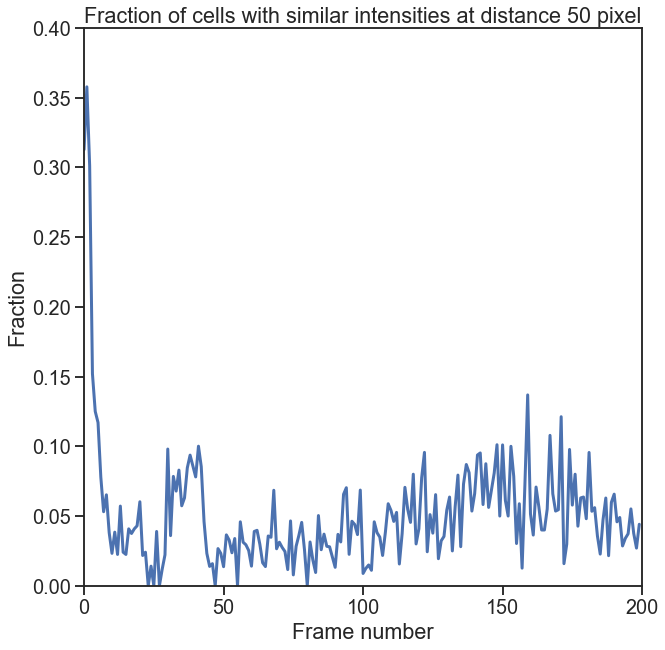

In [127]:
plt.figure(figsize=(10, 10))
plt.plot(frames, fractions)
plt.xlabel('Frame number')
plt.ylabel('Fraction')
_ = plt.title(f'Fraction of cells with similar intensities at distance {radius} pixel')

## 3. Plot how fraction of cells with similar intensity depends on the local “density” 

In [212]:
channel = 'Cy3'
frame_num = 50
patch_size = 600
df_frame = df.loc[df['FRAME'] == frame_num]

frame_name = f'T{frame_num + 1:0>3}'
channel_root = DATA_ROOT / channel
img = cv2.imread(str(channel_root / frame_name), cv2.CV_16U)
height, width = img.shape

patches = []
for top in range(0, height, patch_size):
    for left in  range(0, width, patch_size):
        df_patch = df_frame.loc[(top <= df_frame['POSITION_Y']) & (df_frame['POSITION_Y'] < (top + patch_size)) &
                                (left <= df_frame['POSITION_X']) & (df_frame['POSITION_X'] < (left + patch_size))]
        patches.append(df_patch)

In [213]:
fractions = []
min_intensity = 10
skip_rate = 1
for df_patch in patches:
    intensity_delta, sp_delta = process_frame(df_patch, frame_num, size, skip_rate=skip_rate)
    if len(sp_delta) > 0:
        fraction = (intensity_delta[channel] < min_intensity).sum() / len(intensity_delta[channel])
        fractions.append({'fraction': fraction, 'data_size': len(df_patch)})

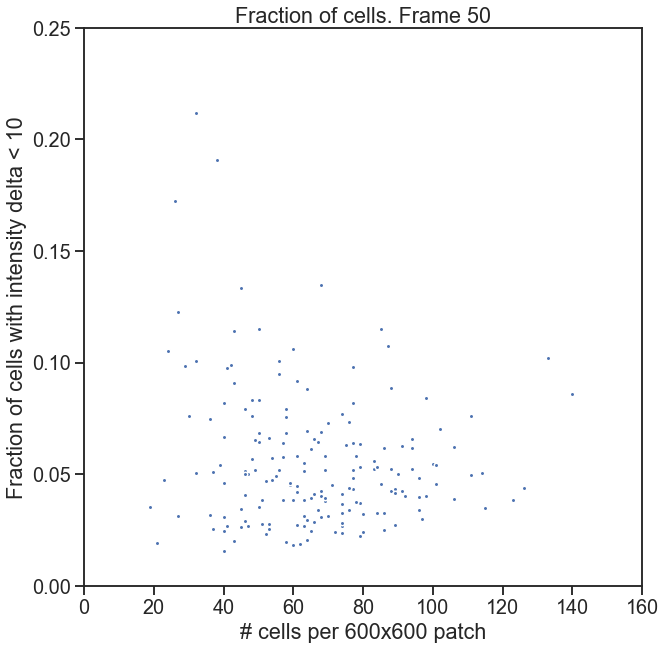

In [216]:
data_size, fraction = zip(*[(v['data_size'], v['fraction']) for v in fractions])

plt.figure(figsize=(10, 10))
plt.scatter(data_size, fraction)
plt.xlabel(f'# cells per {patch_size}x{patch_size} patch')
plt.ylabel(f'Fraction of cells with intensity delta < {min_intensity}')
_ = plt.title(f'Fraction of cells. Frame {frame_num}')

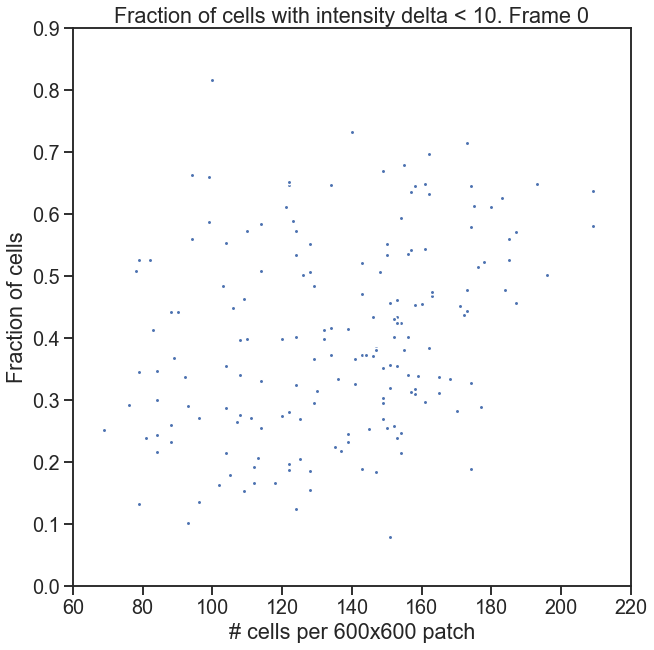

In [211]:
data_size, fraction = zip(*[(v['data_size'], v['fraction']) for v in fractions])

plt.figure(figsize=(10, 10))
plt.scatter(data_size, fraction)
plt.xlabel(f'# cells per {patch_size}x{patch_size} patch')
plt.ylabel('Fraction of cells')
_ = plt.title(f'Fraction of cells with intensity delta < {min_intensity}. Frame {frame_num}')